In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import ast
from datetime import datetime
from collections import Counter
from http.client import responses
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pygsheets
import re
import requests
from tqdm import tqdm


pd.set_option('display.max_colwidth', -1)

In [2]:
url_root_sheet = "https://docs.google.com/spreadsheets/d/1IyfSPiiR0DUxYuConiYzuokM2hUQbOBpuJAeAlGi7kc/edit#gid=223389382"
url_root_sheet = re.sub(r"/edit(.*)", '', url_root_sheet)

In [3]:
with open("data/data.json", "r") as f:
    processed = json.load(f)

df_root = pd.read_csv(processed[url_root_sheet] + "/root.csv", sep=";")
df_root

,ID,Level,Program,Year,Module,Discipline,Teacher,URL,Row,Type,...,9,8,7,6,5,4,3,2,1,0
0,1,Бакалавриат,Программная инженерия,1,"1,2,3,4",Математический анализ,Федотов,https://drive.google.com/drive/folders/1n-ykGVz7eHWG_PgG0RSo-tBcGs_9s3xS?usp=sharing,3,Drive Directory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Бакалавриат,Программная инженерия,1,"2,3",Компьютерный практикум по матанализу на Python,Шайхелисламов Д.С.,https://docs.google.com/spreadsheets/d/1QwLYiokR_V_eYYzpKkOedOQaPY4A07HyzrqjGJgAQ6k,4,Google Sheet,...,457.0,1479.0,251.0,410.0,103.0,160.0,24.0,26.0,83.0,1462.0
2,3,Бакалавриат,Программная инженерия,1,"2,3",Компьютерный практикум по матанализу на Python,Шайхелисламов Д.С.,https://docs.google.com/spreadsheets/d/1QwLYiokR_V_eYYzpKkOedOQaPY4A07HyzrqjGJgAQ6k,4,Google Sheet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Бакалавриат,Программная инженерия,1,"2,3",Компьютерный практикум по математическому анализу в среде Matlab,Макаров С.Л.,http://serjmak.com/2students/matlaba/,5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Бакалавриат,Программная инженерия,1,"1,2,3,4",Алгебра,Чернышев Всеволод Леонидович,https://docs.google.com/spreadsheets/d/1fZEpApQu46aBq_1OO9C03ttjyLWhS_MH_G3SGKvf12A,6,Google Sheet,...,437.0,400.0,198.0,316.0,231.0,219.0,135.0,222.0,159.0,855.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,343,Бакалавриат,Компьютерные науки и анализ данных,1,3,Программирование на С++,Леванов Дмитрий Александрович,https://docs.google.com/spreadsheets/d/1DC7xSS-2ycn-y3cSsegnFpms-wChg3dXMb4DGgE4ZZo,267,Google Sheet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
343,344,Бакалавриат,Компьютерные науки и анализ данных,1,4,Инструменты промышленной разработки,Горшков Сергей Сергеевич,NaN,268,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
344,345,Бакалавриат,Компьютерные науки и анализ данных,1,3-4,Правовая грамотность,Хабибулин Тагир Маратович,NaN,269,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
345,346,Бакалавриат,Компьютерные науки и анализ данных,1,1-4,АЯ для ОиК целей,"Журавлева Анна Петровна, Сафонова Юлия Владимировна",NaN,270,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Анализ качества парсинга

In [4]:
# Недоступные ссылки (либо отказ в доступе, либо ведомость удалена, либо еще что-то)
# Wrong format = гугл таблица сохранена в формате XLSX
df_root[pd.notna(df_root.ErrorName)]

,ID,Level,Program,Year,Module,Discipline,Teacher,URL,Row,Type,...,9,8,7,6,5,4,3,2,1,0
12,13,Бакалавриат,Программная инженерия,1,"1,2,3,4",Дискретная математика,Дашков Евгений Владимирович,https://docs.google.com/spreadsheets/d/1_Et9QKj-o7Jtsju8PZi6GA-v81JYA-pA8HGwasBUQq8,11,Google Sheet,...,431.0,561.0,533.0,259.0,864.0,103.0,139.0,183.0,755.0,7408.0
13,14,Бакалавриат,Программная инженерия,1,"1,2",Введение в программную инженерию,Шилов В.В.,https://docs.google.com/spreadsheets/d/1kRxZ7E0jJ66GitUlEFe42tl8yKPp-1aD,12,Google Sheet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,15,Бакалавриат,Программная инженерия,1,"3,4",Экономика blended,Шевченко Е.С.,https://docs.google.com/spreadsheets/d/1nHYRfFInocrA1Fx80hMEdiNeJC31KQ8wdbl5ycXgw20,13,Google Sheet,...,47.0,61.0,12.0,29.0,30.0,13.0,5.0,9.0,5.0,112.0
15,16,Бакалавриат,Программная инженерия,1,"3,4",Экономика blended,Шевченко Е.С.,https://docs.google.com/spreadsheets/d/19LqlpP86hnl5g6kYVb-EW_zMJunfJkYNu80vHMW47Jc,13,Google Sheet,...,57.0,57.0,11.0,43.0,30.0,11.0,1.0,13.0,4.0,66.0
16,17,Бакалавриат,Программная инженерия,1,"3,4",Экономика blended,Шевченко Е.С.,https://docs.google.com/spreadsheets/d/1YiaRIOYvM_B-X0G3oS3ITP2kNxEDk8UmFyF_w07xJ9U,13,Google Sheet,...,35.0,68.0,18.0,27.0,38.0,12.0,5.0,17.0,4.0,156.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,342,Бакалавриат,Компьютерные науки и анализ данных,1,3,Python для анализа данных,Горшков Сергей Сергеевич,NaN,266,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
343,344,Бакалавриат,Компьютерные науки и анализ данных,1,4,Инструменты промышленной разработки,Горшков Сергей Сергеевич,NaN,268,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
344,345,Бакалавриат,Компьютерные науки и анализ данных,1,3-4,Правовая грамотность,Хабибулин Тагир Маратович,NaN,269,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
345,346,Бакалавриат,Компьютерные науки и анализ данных,1,1-4,АЯ для ОиК целей,"Журавлева Анна Петровна, Сафонова Юлия Владимировна",NaN,270,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Какие ошибки были при парсинге ссылок
# Wrong format = гугл таблица сохранена в формате XLSX
df_root.ErrorName.unique()

array([nan, 'Unable to find the server at oauth2.googleapis.com',
       'Wrong format', 'Gone',
       '<HttpError 403 when requesting https://sheets.googleapis.com/v4/spreadsheets/11h1SLHq7YJ2FHG9qJKMtrJ3QBUzmJadP_lzqfZi-2To?includeGridData=false&fields=%2A&alt=json returned "The caller does not have permission". Details: "The caller does not have permission">',
       '<HttpError 403 when requesting https://sheets.googleapis.com/v4/spreadsheets/11I7czsxNIVUdXXQj7BTuXHEJG9KKaXXdf_UU0zRKr-w?includeGridData=false&fields=%2A&alt=json returned "The caller does not have permission". Details: "The caller does not have permission">',
       'URL invalid',
       '<HttpError 403 when requesting https://sheets.googleapis.com/v4/spreadsheets/1gJHOnOEUDECMxMwcizpdZVBrg_nXfOiLomshBmqLsDs?includeGridData=false&fields=%2A&alt=json returned "The caller does not have permission". Details: "The caller does not have permission">',
       'Not Found',
       '<HttpError 403 when requesting https://shee

In [6]:
# Какие ведомости были удалены
df_root[df_root.ErrorName == "Gone"]

,ID,Level,Program,Year,Module,Discipline,Teacher,URL,Row,Type,...,9,8,7,6,5,4,3,2,1,0
18,19,Бакалавриат,Программная инженерия,1,"3,4",Экономика blended,Шевченко Е.С.,https://docs.google.com/spreadsheets/d/1rbrD3QoCHVWue-t1JaQoKBYh3eeKB_Kw,13,Google Sheet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,20,Бакалавриат,Программная инженерия,1,"3,4",Экономика blended,Шевченко Е.С.,https://docs.google.com/spreadsheets/d/14WOr06eZUHK4YsUZgRG-MdW3b_sf9nMl,13,Google Sheet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,57,Бакалавриат,Программная инженерия,3,"1,2",Математические методы анализа данных (преподается на английском языке),Кузина Анна,https://docs.google.com/spreadsheets/d/1Xf7hJfB5M28uLB7A7NLtJDR5A_xHrl-uvwiT1NnqKGc,42,Google Sheet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,77,Бакалавриат,Программная инженерия,3,"1,2",Разработка IDE,Васильев Андрей Дмитриевич,https://docs.google.com/spreadsheets/d/1-vb7h-hIuPaWt6XnQa6ql3wXA5kAWmTgVctD5Jrte5A,61,Google Sheet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126,127,Бакалавриат,Прикладной анализ данных,2,"1,2,3,4",Теория вероятностей и математическая статистика,Лукьянченко Петр Павлович,https://docs.google.com/spreadsheets/d/1qY2_yFbiBpG_ggxWhYlank1JLQGdfyTqPQ1mafvfufE,102,Google Sheet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,142,Бакалавриат,Прикладной анализ данных,3,"1,2,3,4",Временные ряды и случайные процессы,Лукьянченко Петр Павлович,https://docs.google.com/spreadsheets/d/1Md5d_1X4R7OhJP0mqtPKvSDg0UWpaLpsuzy_LPbzF1M,112,Google Sheet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,146,Бакалавриат,Прикладной анализ данных,3,"3,4",Исследование операций и теория игр БК SAS (вместе с 3 курсом ПМИ),Клемашев Николай Иванович,https://docs.google.com/spreadsheets/d/1Gj1eJdRljTISZhwPM0D9sddKN8GLnyXMYuz_ArTdoFY,116,Google Sheet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162,163,Бакалавриат,Прикладная математика и информатика,1,"1,2,3,4",Английский язык,NaN,https://docs.google.com/spreadsheets/d/1HPNNcGqUnNnHxP_kg8VdoOkZLnZnJBrE,133,Google Sheet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,200,Бакалавриат,Прикладная математика и информатика,1,"1,2,3",Дискретная математика (пилот),Подольский Владимир Владимирович,https://docs.google.com/spreadsheets/d/1S5XMkwGeDDpLvkNtTazY9YW-OMZEBKeXWqyJ_agaUKI,138,Google Sheet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250,251,Бакалавриат,Прикладная математика и информатика,3,"3,4",Исследование операций и теория игр (преподается на английском языке) (вместе с 3 курсом ПАД),Клемашев Н.И.,https://docs.google.com/spreadsheets/d/1Gj1eJdRljTISZhwPM0D9sddKN8GLnyXMYuz_ArTdoFY,176,Google Sheet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
print("Валидных открытых ведомостей всего {} из {}".format(len(df_root[pd.isna(df_root.ErrorName)]), len(df_root)))

Валидных открытых ведомостей всего 88 из 347


In [8]:
print("Форматы ведостей")
print(df_root.Type.unique())

Форматы ведостей
['Drive Directory' 'Google Sheet' nan 'Drive PDF' 'Sharepoint' 'Dropbox']


In [9]:
# Ведомости, которые не были предоставлены
df_root[pd.isna(df_root.URL)]

,ID,Level,Program,Year,Module,Discipline,Teacher,URL,Row,Type,...,9,8,7,6,5,4,3,2,1,0
24,25,Бакалавриат,Программная инженерия,1,4,Основы программирования на С++,Чуйкин Н.К.,NaN,15,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,30,Бакалавриат,Программная инженерия,1,"1,2,3","Научно-исследовательский семинар ""Нейроинформатика”",Харламов А.А.,NaN,20,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,34,Бакалавриат,Программная инженерия,1,"1,2,3,4",факультатив Английский язык,"ШИЯ, менеджер Котрина Елена",NaN,24,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,48,Бакалавриат,Программная инженерия,2,"1,2,3","Научно-исследовательский семинар ""Методы и алгоритмы защиты информации""",Аржанцев И.В.,NaN,33,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,56,Бакалавриат,Программная инженерия,2,"1,2,3",Английский язык,"ШИЯ, менеджер Котрина Елена",NaN,41,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,66,Бакалавриат,Программная инженерия,3,"1,2",Прикладные методы линейной алгебры (преподается на английском языке),Пионтковский Д.И.,NaN,50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,70,Бакалавриат,Программная инженерия,3,"3,4",Распределенные вычисления (преподается на английском языке),Панфилов П.Б.,NaN,54,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,74,Бакалавриат,Программная инженерия,3,"3,4",UX-исследования для создания новых цифровых продуктов (преподается на английском языке),Иванов В.Д.,NaN,58,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,75,Бакалавриат,Программная инженерия,3,"1,2",Верификация программ,Щепетков Илья Викторович,NaN,59,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,76,Бакалавриат,Программная инженерия,3,"3,4",Компиляторные технологии,С.С.Гайсарян,NaN,60,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Ведомости, у которых НЕ определен формат и валидна (и доступна) ссылка на ведомость
df_root[(pd.isna(df_root.Type)) & (pd.notna(df_root.URL))]

,ID,Level,Program,Year,Module,Discipline,Teacher,URL,Row,Type,...,9,8,7,6,5,4,3,2,1,0
3,4,Бакалавриат,Программная инженерия,1,"2,3",Компьютерный практикум по математическому анализу в среде Matlab,Макаров С.Л.,http://serjmak.com/2students/matlaba/,5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,Бакалавриат,Программная инженерия,1,"2,3",Компьютерный практикум по алгебре в среде Matlab,Макаров С.Л.,http://serjmak.com/2students/matlaba/,8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,11,Бакалавриат,Программная инженерия,1,"1,2,3",Программирование на C#,Дударев В.А.,https://edu.hse.ru/grade/report/grader/index.php?id=105244,9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,53,Бакалавриат,Программная инженерия,2,"1,2,3","Научно-исследовательский семинар ""Разработка облачных и мобильных приложений на платформе Google Android""",Макаров С.Л.,https://tinyurl.com/dkurvaps,38,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,63,Бакалавриат,Программная инженерия,3,"3,4",Проектирование архитектуры программных систем,Мицюк А.А.,https://edu.hse.ru/grade/report/index.php?id=111100,47,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,65,Бакалавриат,Программная инженерия,3,"1,2",Экосистемы интернета вещей (преподается на английском языке),Макаров С.Л.,https://tinyurl.com/3u4f57jh,49,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,104,Бакалавриат,Программная инженерия,4,"1,2,3","Научно-исследовательский семинар ""Тренды облачной и мобильной разработки""",Макаров С.Л.,https://tinyurl.com/upn827mk,88,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,110,Бакалавриат,Прикладной анализ данных,1,"1,2",Основы права blended,Журавлев Михаил Сергеевич,https://drive.google.com/open?id=1Kid4BcZ2YhTynUD_LUndlgofzoFOzuWK,94,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139,140,Бакалавриат,Прикладной анализ данных,3,"1,2,3,4",Машинное обучение 1 (лекции вместе с МИЭФ/ online via Zoom),Мельников Олег,https://drive.google.com/open?id=1zNBo7B7deoZyEDDpxpNF9Q1BFxejDnh0,110,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206,207,Бакалавриат,Прикладная математика и информатика,1,"1,2,3,4",Линейная алгебра и геометрия (пилот),Трушин Дмитрий Витальевич,http://wiki.cs.hse.ru/%D0%9B%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%B0%D1%8F_%D0%B0%D0%BB%D0%B3%D0%B5%D0%B1%D1%80%D0%B0_%D0%B8_%D0%B3%D0%B5%D0%BE%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D1%8F_%D0%BD%D0%B0_%D0%9F%D0%9C%D0%98_2021/2022_(%D0%BF%D0%B8%D0%BB%D0%BE%D1%82%D0%BD%D1%8B%D0%B9_%D0%BF%D0%BE%D1%82%D0%BE%D0%BA)#.D0.92.D0.B5.D0.B4.D0.BE.D0.BC.D0.BE.D1.81.D1.82.D0.B8_.D1.82.D0.B5.D0.BA.D1.83.D1.89.D0.B5.D0.B3.D0.BE_.D0.BA.D0.BE.D0.BD.D1.82.D1.80.D0.BE.D0.BB.D1.8F,140,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
with open("config/config.json", "r") as f:
    config = json.load(f)

for url_type in config["URL_TYPE"].values():
    cnt_type = len(df_root[df_root.Type == url_type])
    cnt_type_url = len(df_root[(df_root.Type == url_type) & (pd.isna(df_root.ErrorName))])
    print("{}: valid and accessible {} out of {}".format(url_type, cnt_type_url, cnt_type))
    
cnt_unknown_url = len(df_root[(pd.isna(df_root.Type)) & (pd.notna(df_root.URL))])
cnt_unknown = len(df_root[pd.isna(df_root.Type)])
print("\nValid and accessible of unknown type:", cnt_unknown_url, "out of", cnt_unknown)

Google Sheet: valid and accessible 30 out of 237
Drive Directory: valid and accessible 5 out of 5
Drive PDF: valid and accessible 13 out of 13
Drive Unknown File: valid and accessible 0 out of 0
Sharepoint: valid and accessible 4 out of 6
MS Teams: valid and accessible 0 out of 0
Dropbox: valid and accessible 10 out of 10

Valid and accessible of unknown type: 26 out of 76


In [12]:
import math

print("Среди всех ведомостей\n")
for url_type in config["URL_TYPE"].values():
    cnt = len(df_root[df_root.Type == url_type])
    print("{} ~ {} %".format(url_type, math.ceil(100 * cnt / len(df_root))))

cnt = len(df_root[pd.isna(df_root.Type)])
print("\nOther types ~", math.ceil(100 * cnt / len(df_root)), "%")

Среди всех ведомостей

Google Sheet ~ 69 %
Drive Directory ~ 2 %
Drive PDF ~ 4 %
Drive Unknown File ~ 0 %
Sharepoint ~ 2 %
MS Teams ~ 0 %
Dropbox ~ 3 %

Other types ~ 22 %


In [13]:
print("Среди доступных ведомостей\n")
for url_type in config["URL_TYPE"].values():
    cnt = len(df_root[(df_root.Type == url_type) & (pd.isna(df_root.ErrorName))])
    print("{} ~ {} %".format(url_type, math.ceil(100 * cnt / len(df_root[pd.isna(df_root.ErrorName)]))))

cnt = len(df_root[pd.isna(df_root.Type) & (pd.isna(df_root.ErrorName))])
print("\nOther types ~", math.ceil(100 * cnt / len(df_root[pd.isna(df_root.ErrorName)])), "%")

Среди доступных ведомостей

Google Sheet ~ 35 %
Drive Directory ~ 6 %
Drive PDF ~ 15 %
Drive Unknown File ~ 0 %
Sharepoint ~ 5 %
MS Teams ~ 0 %
Dropbox ~ 12 %

Other types ~ 30 %


In [14]:
for error in df_root.ErrorName.unique():
    if pd.notna(error):
        cnt = len(df_root[df_root.ErrorName == error])
        print("{}: {}".format(error, cnt))

Unable to find the server at oauth2.googleapis.com: 125
Wrong format: 55
Gone: 11
<HttpError 403 when requesting https://sheets.googleapis.com/v4/spreadsheets/11h1SLHq7YJ2FHG9qJKMtrJ3QBUzmJadP_lzqfZi-2To?includeGridData=false&fields=%2A&alt=json returned "The caller does not have permission". Details: "The caller does not have permission">: 1
<HttpError 403 when requesting https://sheets.googleapis.com/v4/spreadsheets/11I7czsxNIVUdXXQj7BTuXHEJG9KKaXXdf_UU0zRKr-w?includeGridData=false&fields=%2A&alt=json returned "The caller does not have permission". Details: "The caller does not have permission">: 1
URL invalid: 50
<HttpError 403 when requesting https://sheets.googleapis.com/v4/spreadsheets/1gJHOnOEUDECMxMwcizpdZVBrg_nXfOiLomshBmqLsDs?includeGridData=false&fields=%2A&alt=json returned "The caller does not have permission". Details: "The caller does not have permission">: 1
Not Found: 2
<HttpError 403 when requesting https://sheets.googleapis.com/v4/spreadsheets/1dJxb-yFrSq0UPVIFrm27c9

# Анализ стат. информации по ведомостям

In [15]:
tmp = df_root.groupby(by=["Level", "Program", "Year", "Module", "Discipline", "Teacher"]).sum()
tmp[tmp.MeanMark > 0][["10", "9", "8", "7", "6", "5", "4", "3", "2", "1", "0"]]

10  \
Level       Program                             Year Module Discipline                                                                             Teacher                                                                                     
Бакалавриат Компьютерные науки и анализ данных  1    1      Программирование на Python                                                             Горшков Сергей Сергеевич                                                          245.0     
                                                     1-2    Дискретная математика                                                                  Мажуга Андрей Михайлович                                                          304.0     
                                                     1-4    Линейная алгебра                                                                       Гайфуллин Сергей Александрович                                                    86.0      
                                                     2,4    Алгоритмы и структуры данных                                                           Густокашин Михаил Сергеевич (2 модуль) Куренков Владимир Вячеславович (4 модуль)  67.0      
            Прикладная математика и информатика 1    1      ОиМП (основа)                                                                          Михеев Александр Георгиевич                                                       26020.0   
...                                                                                                                                                                                                                                   ...      
            Программная инженерия               4    1,2    Интеллектуальное право                                                                 Жарова А.К.                                                                       137.0     
                                                     1,2,3  Исследование операций (МКД)                                                            Жукова Г.Н.                                                                       8.0       
                                                            Математические методы систем распределенного реестра (преподается на английском языке) Янович Ю.А.                                                                       68.0      
                                                            Разработка операционных систем                                                         Хорошилов А.В.                                                                    4.0       
                                                            Управление качеством бизнес-приложений                                                 Плотников А.В.                                                                    8.0       

                                                                                                                                                                                                                                         9  \
Level       Program                             Year Module Discipline                                                                             Teacher                                                                                   
Бакалавриат Компьютерные науки и анализ данных  1    1      Программирование на Python                                                             Горшков Сергей Сергеевич                                                          60.0    
                                                     1-2    Дискретная математика                                                                  Мажуга Андрей Михайлович                                                          7.0     
                                                     1-4    Линейная алгебра                                                                       Гайфуллин Серг

In [16]:
len(tmp)

267

In [17]:
len(df_root)

347

In [18]:
df_root[df_root.IsParsed == True]

,ID,Level,Program,Year,Module,Discipline,Teacher,URL,Row,Type,...,9,8,7,6,5,4,3,2,1,0
1,2,Бакалавриат,Программная инженерия,1,"2,3",Компьютерный практикум по матанализу на Python,Шайхелисламов Д.С.,https://docs.google.com/spreadsheets/d/1QwLYiokR_V_eYYzpKkOedOQaPY4A07HyzrqjGJgAQ6k,4,Google Sheet,...,457.0,1479.0,251.0,410.0,103.0,160.0,24.0,26.0,83.0,1462.0
4,5,Бакалавриат,Программная инженерия,1,"1,2,3,4",Алгебра,Чернышев Всеволод Леонидович,https://docs.google.com/spreadsheets/d/1fZEpApQu46aBq_1OO9C03ttjyLWhS_MH_G3SGKvf12A,6,Google Sheet,...,437.0,400.0,198.0,316.0,231.0,219.0,135.0,222.0,159.0,855.0
8,9,Бакалавриат,Программная инженерия,1,"1,2,3",Программирование на C#,Дударев В.А.,https://docs.google.com/spreadsheets/d/1-QFsZNikCjVGx7rwRFq1FncGM5c-lUpukEmLv009NlI,9,Google Sheet,...,0.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0,25.0
12,13,Бакалавриат,Программная инженерия,1,"1,2,3,4",Дискретная математика,Дашков Евгений Владимирович,https://docs.google.com/spreadsheets/d/1_Et9QKj-o7Jtsju8PZi6GA-v81JYA-pA8HGwasBUQq8,11,Google Sheet,...,431.0,561.0,533.0,259.0,864.0,103.0,139.0,183.0,755.0,7408.0
14,15,Бакалавриат,Программная инженерия,1,"3,4",Экономика blended,Шевченко Е.С.,https://docs.google.com/spreadsheets/d/1nHYRfFInocrA1Fx80hMEdiNeJC31KQ8wdbl5ycXgw20,13,Google Sheet,...,47.0,61.0,12.0,29.0,30.0,13.0,5.0,9.0,5.0,112.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,330,Бакалавриат,Прикладная математика и информатика,4,"1,2,3","Научно-исследовательский семинар ""Принятие решений - прикладные задачи 2"" **",Алескеров Ф.Т.,https://docs.google.com/spreadsheets/d/17GWIoU3J4W_wLg4KDJB3gLSiVu33laqMZHZ_DWxDUzM,255,Google Sheet,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
335,336,Бакалавриат,Компьютерные науки и анализ данных,1,1-2,Дискретная математика,Мажуга Андрей Михайлович,https://docs.google.com/spreadsheets/d/1YM_NPfRHux7gLDblkH_XkYGSk_V5-dMZPqJ6ANQj8P0,261,Google Sheet,...,7.0,8.0,3.0,1.0,15.0,0.0,0.0,0.0,2.0,212.0
338,339,Бакалавриат,Компьютерные науки и анализ данных,1,1-4,Линейная алгебра,Гайфуллин Сергей Александрович,https://docs.google.com/spreadsheets/d/1xpKnjde1SyySruR7PCPObEBbxciVHkfnYDVxH4WDSFw,264,Google Sheet,...,21.0,19.0,17.0,10.0,23.0,13.0,17.0,14.0,16.0,116.0
340,341,Бакалавриат,Компьютерные науки и анализ данных,1,"2,4",Алгоритмы и структуры данных,Густокашин Михаил Сергеевич (2 модуль) Куренков Владимир Вячеславович (4 модуль),https://docs.google.com/spreadsheets/d/15JlUgoYD14KAEuObkgZ-BQ04MhSUmguU8jkMIPn1mOo,265,Google Sheet,...,17.0,37.0,21.0,21.0,34.0,15.0,3.0,13.0,3.0,168.0


In [31]:
# Анализ конкретной ведомости
parsed_df = df_root[df_root.IsParsed == True]
path = parsed_df.iloc[3].Path
df_sheet = pd.read_csv(path, sep=";")
print(path)
df_sheet

data/2023-05-21_18:39:29/statements/БПИ_1курс_1,2,3,4модуль_Дискретная_математика_Дашков.csv


,ID,Student,Group,MarksDict,MarksNorm,MeanMark,MeanPositiveMark,MarkSum,MarkCount,MarkPositiveCount,...,9,8,7,6,5,4,3,2,1,0
0,1,Абиев Марик Олегович,NaN,"{'группа (B)': 211.0, 'HW2 (C)': 8.765957447, 'КР-1 (D)': 7.0, 'КР-2 (E)': 4.5}","[0.9995262908574135, 7.754500815815749, 8.75, 6.428571428571429]",5.983150,5.983150,23.932599,4,4,...,1,1,0,1,0,0,0,0,1,0
1,2,Александрова Анастасия Васильевна,NaN,"{'группа (B)': 211.0, 'HW2 (C)': 9.446808511, 'КР-1 (D)': 2.5, 'КР-2 (E)': 5.7}","[0.9995262908574135, 8.356792141453418, 3.125, 8.142857142857142]",5.156044,5.156044,20.624176,4,4,...,0,2,0,0,0,0,1,0,1,0
2,4,Безруков Михаил Александрович,NaN,"{'группа (B)': 211.0, 'HW2 (C)': 9.234042553, 'КР-1 (D)': 6.0, 'КР-2 (E)': 3.4}","[0.9995262908574135, 8.16857610174934, 7.5, 4.857142857142857]",5.381311,5.381311,21.525245,4,4,...,0,2,0,0,1,0,0,0,1,0
3,5,Воробьев Артём Александрович,NaN,"{'группа (B)': 211.0, 'HW2 (C)': 7.340425532, 'КР-1 (D)': 3.0, 'КР-2 (E)': 2.7}","[0.9995262908574135, 6.493453352983036, 3.75, 3.857142857142857]",3.775031,3.775031,15.100123,4,4,...,0,0,0,1,0,2,0,0,1,0
4,6,Данилов Никита Александрович,NaN,"{'группа (B)': 211.0, 'HW2 (C)': 6.531914894, 'КР-1 (D)': 5.0, 'КР-2 (E)': 5.4}","[0.9995262908574135, 5.778232404230612, 6.25, 7.714285714285714]",5.185511,5.185511,20.742044,4,4,...,0,1,0,2,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,23,Степанов Алексей Александрович,NaN,"{' (B)': 3.0, ' (C)': 3.0, ' (D)': 1.0, ' (E)': 4.0, ' (F)': 2.0, ' (G)': 1.0, ' (I)': 1.0, ' (K)': 1.0, ' (L)': 1.0, ' (M)': 0.0, ' (N)': 1.0, ' (O)': 1.0, ' (P)': 1.0, ' (Q)': 1.0, ' (R)': 0.0, ' (S)': 0.0, ' (T)': 0.0, ' (U)': 0.0, ' (V)': 1.0, ' (W)': 1.0, ' (X)': 0.0, ' (Y)': 1.0, ' (Z)': 1.0, ' (AA)': 0.8, ' (AB)': 0.2, ' (AC)': 0.0, ' (AD)': 0.0, ' (AE)': 0.0, ' (AF)': 1.0, ' (AG)': 1.0, ' (AH)': 0.9, ' (AI)': 0.7, ' (AJ)': 0.9, ' (AM)': 1.0, ' (AN)': 1.0, ' (AO)': 1.0, ' (AP)': 0.9, ' (AQ)': 1.0, ' (AR)': 1.0, ' (AS)': 0.5, ' (AT)': 0.5, ' (AU)': 1.0, ' (AV)': 1.0, ' (AW)': 0.95, ' (AX)': 0.8, ' (AY)': 0.5, ' (AZ)': 0.0, ' (BA)': 1.0, ' (BB)': 0.7, ' (BE)': 1.0, 'a (BF)': 0.8, 'b (BG)': 0.8, 'a (BH)': 1.0, 'b (BI)': 0.0, ' (BJ)': 1.0, ' (BK)': 1.0, ' (BL)': 0.7, 'a (BM)': 1.0, 'b (BN)': 1.0, 'c (BO)': 1.0, ' (BP)': 0.0, ' (BQ)': 1.0, 'a (BR)': 0.5, 'b (BS)': 0.5, 'a (BT)': 1.0, 'b (BU)': 1.0, 'c (BV)': 0.1, 'd (BW)': 0.95, ' (BX)': 1.0, ' (BY)': 0, ' (BZ)': 0.1, ' (CC)': 1.0, ' (CD)': 1.0, ' (CE)': 1.0, ' (CF)': 0.1, ' (CG)': 1.0, ' (CH)': 1.0, ' (CI)': 1.0, 'a (CJ)': 0, 'b (CK)': 0, 'c (CL)': 0, ' (CM)': 1.0, ' (CN)': 0.95, ' (CO)': 1.0, ' (CP)': 1.0, ' (CQ)': 0.95, ' (CR)': 0.5, ' (CS)': 1.0, ' (CT)': 1.0, ' (CU)': 0, ' (CX)': 1.0, '1 (CY)': 1.0, '2 (CZ)': 1.0, '3 (DA)': 0.0, '4 (DB)': 0.0, '5 (DC)': 1.0, '6 (DD)': 0.0, '7 (DE)': 0, '8 (DF)': 1.0, 'a (DH)': 1.0, ' b (DI)': 1.0, ' (DJ)': 0.1, ' (DK)': 0.1, ' (DL)': 1.0, ' (DM)': 0.0, ' (DN)': 1.0, ' (DO)': 1.0, ' (DP)': 0.5, ' (DQ)': 0.1, ' (DR)': 1.0, ' (DS)': 1.0, ' (DT)': 0.7, ' (DU)': 1.0, ' (DV)': 1.0, ' (DY)': 1.0, ' (DZ)': 0.1, ' (EA)': 0, 'a (EB)': 1.0, 'b (EC)': 1.0, ' (ED)': 0.0, 'a (EE)': 1.0, 'b (EF)': 0.0, ' (EG)': 0.5, 'a (EH)': 1.0, 'b (EI)': 1.0, 'a (EJ)': 0.95, 'b (EK)': 0.95, 'c (EL)': 0.95, 'a (EM)': 1.0, 'b (EN)': 0.5, ' (EO)': 1.0, 'a (EP)': 0, ' (ET)': 1.0, 'a (EU)': 1.0, 'b (EV)': 1.0, 'c (EW)': 1.0, ' (EX)': 1.0, ' (EY)': 1.0, ' (EZ)': 1.0, ' (FA)': 1.0, ' (FB)': 1.0, ' (FC)': 1.0, 'a (FD)': 0.8, 'b (FE)': 1.0, 'c (FF)': 0.0, ' (FG)': 1.0, ' (FH)': 0, 'a (FJ)': 0.0, 'b (FK)': 0.0, 'c (FL)': 1.0, ' (FM)': 0, ' (FQ)': 1.0, '1 (FR)': 1.0, '2 (FS)': 0, '3 (FT)': 1.0, '4 (FU)': 1.0, '5 (FV)': 0.0, '6 (FW)': 0.0, '7 (FX)': 1.0}","[10.0, 10.0, 10.0, 6.666666666666667, 5.0, 10.0, 10.0, 10.0, 10.0, 0.0, 10.0, 10.0, 10.0, 10.0, 0.0, 0.0, 0.0, 0.0, 10.0, 10.0, 0.0, 10.0, 10.0, 8.0, 2.0, 0.0, 0.0, 0.0, 10.0, 10.0, 9.0, 7.0, 9.0, 10.0, 10.0, 10.0, 9.0, 10.0, 10.0, 5.0, 5.0, 10.0, 10.0, 9.5, 8.0, 5.0, 0.0, 10.0, 7.0, 10.0, 

In [32]:
len(df_sheet.Student.unique())

244

<BarContainer object of 89 artists>

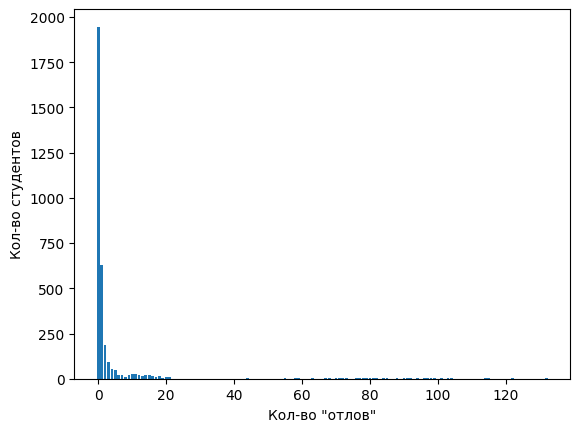

In [33]:
excellent_lst = df_sheet["10"].to_list()
excellent_lst.extend(df_sheet["9"].to_list())
excellent_lst.extend(df_sheet["8"].to_list())
excellent = Counter(excellent_lst)
excellent_x, excellent_y = excellent.keys(), excellent.values()
plt.xlabel("Кол-во \"отлов\"")
plt.ylabel("Кол-во студентов")
plt.bar(excellent_x, excellent_y)

<BarContainer object of 8 artists>

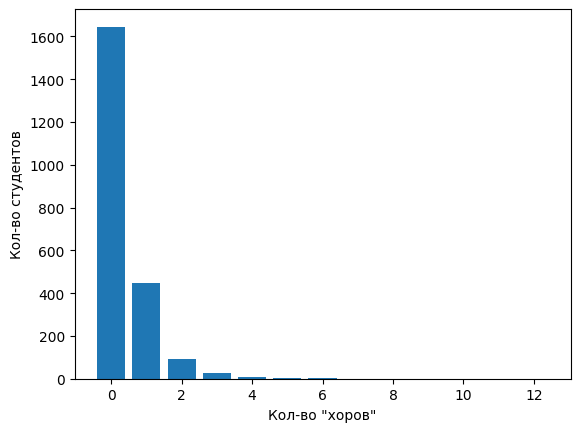

In [34]:
good_lst = df_sheet["7"].to_list()
good_lst.extend(df_sheet["6"].to_list())
good = Counter(good_lst)
good_x, good_y = good.keys(), good.values()
plt.xlabel("Кол-во \"хоров\"")
plt.ylabel("Кол-во студентов")
plt.bar(good_x, good_y)

<BarContainer object of 13 artists>

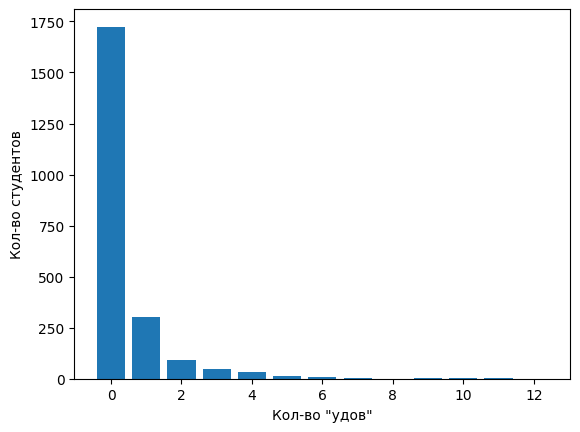

In [35]:
satisfactory_lst = df_sheet["5"].to_list()
satisfactory_lst.extend(df_sheet["4"].to_list())
satisfactory = Counter(satisfactory_lst)
satisfactory_x, satisfactory_y = satisfactory.keys(), satisfactory.values()
plt.xlabel("Кол-во \"удов\"")
plt.ylabel("Кол-во студентов")
plt.bar(satisfactory_x, satisfactory_y)

<BarContainer object of 71 artists>

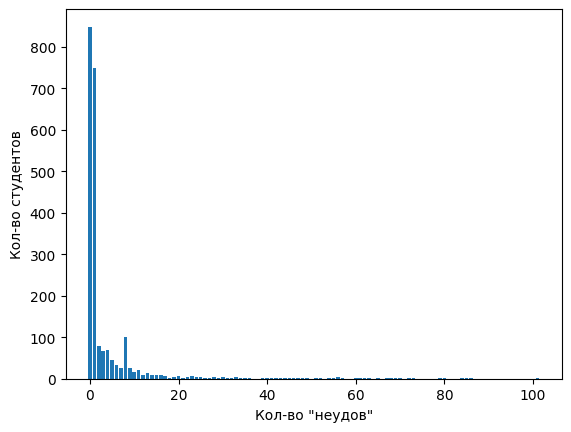

In [36]:
fail_lst = df_sheet["3"].to_list()
fail_lst.extend(df_sheet["2"].to_list())
fail_lst = df_sheet["1"].to_list()
fail_lst.extend(df_sheet["0"].to_list())
fail = Counter(fail_lst)
fail_x, fail_y = fail.keys(), fail.values()
plt.xlabel("Кол-во \"неудов\"")
plt.ylabel("Кол-во студентов")
plt.bar(fail_x, fail_y)

<BarContainer object of 4 artists>

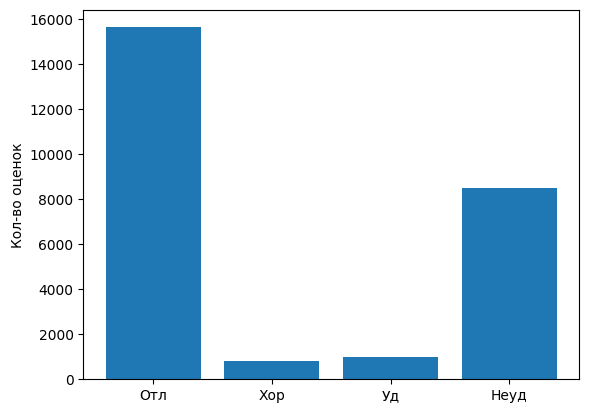

In [37]:
plt.ylabel("Кол-во оценок")
sm_excellent = sum([df_sheet["10"].sum(), df_sheet["9"].sum(), df_sheet["8"].sum()])
sm_good = sum([df_sheet["7"].sum(), df_sheet["6"].sum()])
sm_satisfactory = sum([df_sheet["5"].sum(), df_sheet["4"].sum()])
sm_fail = sum([df_sheet["3"].sum(), df_sheet["2"].sum(), df_sheet["1"].sum(), df_sheet["0"].sum()])
plt.bar(["Отл", "Хор", "Уд", "Неуд"], [sm_excellent, sm_good, sm_satisfactory, sm_fail])

In [62]:
# Ведомости с завышением
stat1 = (df_root["10"] + df_root["9"] + df_root["8"]) / df_root["MarkCount"]
stat2 = df_root["10"] / df_root["MarkCount"]
ind = set(stat1[stat1 > 0.5].index) & set(stat2[stat2 > 0.3].index)
df_root.loc[list(ind)]

,ID,Level,Program,Year,Module,Discipline,Teacher,URL,Row,Type,...,9,8,7,6,5,4,3,2,1,0
260,261,Бакалавриат,Прикладная математика и информатика,3,"1,2",Язык SQL,Моргунов Евгений Павлович,https://docs.google.com/spreadsheets/d/1v5f5ULUtxEf7VbvoXbquVOzKsH-I6QeiZahP9K4M6Mg,186,Google Sheet,...,106.0,42.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0
265,266,Бакалавриат,Прикладная математика и информатика,3,"1,2",Функциональное программирование (с 4 курсом),Кузнецов Степан Львович,https://docs.google.com/spreadsheets/d/1oF8-huXk0nxApTUIu22JCZjBODRMhi8Lbrch1iuhHco,191,Google Sheet,...,3.0,2.0,1.0,3.0,22.0,1.0,0.0,1.0,0.0,133.0
12,13,Бакалавриат,Программная инженерия,1,"1,2,3,4",Дискретная математика,Дашков Евгений Владимирович,https://docs.google.com/spreadsheets/d/1_Et9QKj-o7Jtsju8PZi6GA-v81JYA-pA8HGwasBUQq8,11,Google Sheet,...,431.0,561.0,533.0,259.0,864.0,103.0,139.0,183.0,755.0,7408.0
14,15,Бакалавриат,Программная инженерия,1,"3,4",Экономика blended,Шевченко Е.С.,https://docs.google.com/spreadsheets/d/1nHYRfFInocrA1Fx80hMEdiNeJC31KQ8wdbl5ycXgw20,13,Google Sheet,...,47.0,61.0,12.0,29.0,30.0,13.0,5.0,9.0,5.0,112.0
15,16,Бакалавриат,Программная инженерия,1,"3,4",Экономика blended,Шевченко Е.С.,https://docs.google.com/spreadsheets/d/19LqlpP86hnl5g6kYVb-EW_zMJunfJkYNu80vHMW47Jc,13,Google Sheet,...,57.0,57.0,11.0,43.0,30.0,11.0,1.0,13.0,4.0,66.0
274,275,Бакалавриат,Прикладная математика и информатика,3,"3,4",Моделирование временных рядов,Демешев Борис Борисовичъ,https://docs.google.com/spreadsheets/d/1TQh8d80ZkiNrvbKVBnk7CBWq3L1-K7yJSgmP8Ty9GxM,200,Google Sheet,...,24.0,20.0,15.0,12.0,8.0,8.0,8.0,2.0,2.0,47.0
276,277,Бакалавриат,Прикладная математика и информатика,3,"1,2,3,4","Научно-исследовательский семинар ""Машинное обучение и приложения""",-,https://docs.google.com/spreadsheets/d/1rRMd_h2u36dj3nlBj1MaHe9G0ISAw1jBU35cEdNLh8Q,202,Google Sheet,...,285.0,370.0,202.0,188.0,148.0,87.0,68.0,43.0,29.0,454.0
282,283,Бакалавриат,Прикладная математика и информатика,3,"1,2,3,4","Проектный семинар ""Промышленная разработка""",-,https://docs.google.com/spreadsheets/d/11Hdp6yElldz4xvAN-uw3pgpWFhAs5kTKGqv6mo6ut2A,208,Google Sheet,...,43.0,65.0,26.0,24.0,10.0,11.0,3.0,0.0,6.0,315.0
284,285,Бакалавриат,Прикладная математика и информатика,4,3,Соревновательный анализ данных (преподается на английском языке) blended,Вакансия,https://docs.google.com/spreadsheets/d/1Qm9CuTXrTf0XflvAzaoebf1pGhmTliRTOIS_WACOu2I,210,Google Sheet,...,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,8.0
28,29,Бакалавриат,Программная инженерия,1,"1,2,3","Научно-исследовательский семинар ""Дистрибьюция программного обеспечения в Linux""",Силаков Д.В.,https://docs.google.com/spreadsheets/d/1y1aReyvxaO8RYi9AbqSM76DJFrH-JXwgJ-Z4-3MwxPo,19,Google Sheet,...,5.0,5.0,1.0,1.0,5.0,0.0,0.0,0.0,1.0,12.0


## Анализ успеваемостей

In [63]:
df_students = pd.read_csv(processed[url_root_sheet] + "/students.csv", sep=";")
df_students[df_students.MarkCount > 0]

,ID,Name,Year,Group,Program,MeanMark,MeanPositiveMark,MarkSum,MarkCount,MarkPositiveCount,...,9,8,7,6,5,4,3,2,1,0
0,2,Бейгер Герман Юрьевич,2,БКНАД211,Компьютерные науки и анализ данных,4.521626,8.168098,506.422063,112,62,...,1,9,3,2,5,1,1,4,1,50
1,3,Ишутина Полина Дмитриевна,2,БКНАД211,Компьютерные науки и анализ данных,3.314712,7.813250,437.541999,132,56,...,4,3,3,2,3,1,1,5,3,76
3,5,Котельников Андрей Александрович,2,БКНАД211,Компьютерные науки и анализ данных,5.429048,8.957929,716.634281,132,80,...,1,2,4,4,4,2,0,0,2,52
4,6,Красновид Анжелика Евгеньевна,2,БКНАД211,Компьютерные науки и анализ данных,3.991036,8.283283,439.014008,110,53,...,5,5,2,0,4,2,3,0,2,57
5,7,Креславский Максим Игоревич,2,БКНАД211,Компьютерные науки и анализ данных,3.429866,6.713780,315.547660,92,47,...,3,8,7,2,1,6,3,4,1,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3202,3405,Олейник Михаил Витальевич,1,мФТиАД22,Финансовые технологии и анализ данных,8.587722,8.587722,25.763166,3,3,...,2,1,0,0,0,0,0,0,0,0
3208,3411,Селезнев Максим Романович,1,мФТиАД22,Финансовые технологии и анализ данных,8.919268,8.919268,26.757805,3,3,...,0,0,1,0,0,0,0,0,0,0
3209,3412,Скворцов Иван Александрович,1,мФТиАД22,Финансовые технологии и анализ данных,8.705781,9.794004,156.704066,18,16,...,2,0,0,0,0,0,0,0,0,2
3210,3413,Смирнов Никита Валерьевич,1,мФТиАД22,Финансовые технологии и анализ данных,8.333333,9.722222,175.000000,21,18,...,0,0,0,0,1,0,0,0,0,3


In [71]:
# Студенты с низкой успеваемостью
df_students["Fail"] = df_students[["0", "1", "2", "3"]].sum(axis=1)
df_students["FailPercent"] = df_students["Fail"] / df_students["MarkCount"]
tmp = df_students.sort_values(by="FailPercent", ascending=False)[:]
tmp[:int(0.05 * len(tmp))]

,ID,Name,Year,Group,Program,MeanMark,MeanPositiveMark,MarkSum,MarkCount,MarkPositiveCount,...,7,6,5,4,3,2,1,0,Fail,FailPercent
1392,1458,Ситкарев Александр Алексеевич,4,БПМИ184,Прикладная математика и информатика,0.000000,0.000000,0.000000,20,0,...,0,0,0,0,0,0,0,20,20,1.000000
427,452,Баранов Александр Викторович,4,БПИ183,Программная инженерия,0.000000,0.000000,0.000000,4,0,...,0,0,0,0,0,0,0,4,4,1.000000
2160,2258,Ройтерштейн Антон Дмитриевич,2,БПМИ219,Прикладная математика и информатика,0.015297,1.024876,1.024876,67,1,...,0,0,0,0,0,0,1,66,67,1.000000
1314,1372,Маслихин Илья Аркадьевич,1,БПИ227,Программная инженерия,0.000000,0.000000,0.000000,5,0,...,0,0,0,0,0,0,0,5,5,1.000000
1341,1400,Полушин Артём Алексеевич,1,БПИ228,Программная инженерия,2.137175,2.612103,23.508924,11,9,...,0,0,0,0,6,2,1,2,11,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,814,Мурашкин Михаил Павлович,3,БПИ205,Программная инженерия,3.083581,8.745524,1547.957770,502,177,...,9,7,6,1,2,3,4,325,334,0.665339
1864,1951,Дыбнов Никита Сергеевич,3,БПМИ208,Прикладная математика и информатика,2.730436,6.113803,281.234954,103,46,...,2,5,7,3,4,4,2,58,68,0.660194
1707,1788,Бельский Антон Александрович,3,БПМИ202,Прикладная математика и информатика,2.474436,4.758530,123.721776,50,26,...,2,2,1,7,4,3,2,24,33,0.660000
2127,2224,Медведева Анастасия Алексеевна,2,БПМИ218,Прикладная математика и информатика,2.582853,7.074770,325.439435,126,46,...,5,3,13,1,1,2,0,80,83,0.658730


## Вытаскиваем данные из csv

In [72]:
ast.literal_eval(df_sheet.MarksDict[0])

{'группа (B)': 211.0, 'HW2 (C)': 8.765957447, 'КР-1 (D)': 7.0, 'КР-2 (E)': 4.5}

In [73]:
ast.literal_eval(df_sheet.MarksNorm[0])

[0.9995262908574135, 7.754500815815749, 8.75, 6.428571428571429]